# 2.5 웹 검색을 지원하는 Corrective RAG

- [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884)논문을 구현합니다
- LangGraph 공식문서에 나온 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다.
    - 실제 논문과 유사한 구현은 3.3강을 참고해주세요
![corrective-rag](./images/corrective-rag.png)

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 상태.

    Returns:
        AgentState: 검색된 문서가 추가된 상태를 반환합니다.
    """
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [6]:
from langchain import hub

# 허브에서 RAG 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    """
    주어진 상태를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 상태.

    Returns:
        AgentState: 생성된 응답을 포함하는 상태를 반환합니다.
    """
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response.content}

/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- `retrieve` 노드에서 추출된 문서와 사용자의 질문이 관련이 있는지 판단합니다
    - 문서와 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경합니다
        - `rewrite` 후 다시 `web_search` 노드로 이동해서 웹 검색을 합니다
    - 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성합니다

In [7]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain import hub
from typing import Literal
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelvant']:
    """
    주어진 상태를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 상태.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelvant'

/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {query}
""")

def rewrite(state: AgentState):
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 상태.

    Returns:
        AgentState: 변경된 질문을 포함하는 상태를 반환합니다.
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})

    return {'query': response}


- `web_search` 노드에서 웹 검색을 합니다
- `retrieve` 결과 대신 웹 검색 결과를 사용합니다
    - 웹 검색 결과는 [TavilySearchResults](https://tavily.com/) 툴을 사용합니다

In [9]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    """
    주어진 상태를 기반으로 웹 검색을 수행합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 상태.

    Returns:
        AgentState: 웹 검색 결과가 추가된 상태를 반환합니다.
    """
    query = state['query']
    results = tavily_search_tool.invoke(query)

    return {'context': results}

- `node`를 추가하고 `edge`로 연결합니다

In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
# graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelvant': 'web_search'
    }
)
# graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

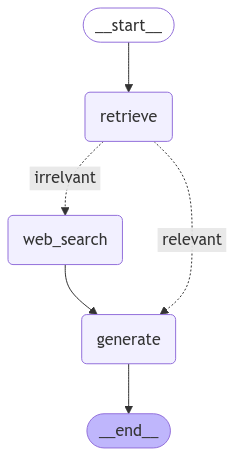

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과세표준의 6개 구간 │\n├───────────────┤\n│ 1,400

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과세

In [15]:
initial_state = {'query': '역삼역 맛집을 추천해주세요'}
graph.invoke(initial_state)

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='담당세무서로서 담당공무원에게 지명이음으로는 보호를 위하는 바에 따라 담의 다음을 말하기는 것에 대한 해상금의 숙소는 본 해당하는 숙소는 달의 다음과 함께 말할 것이다. <개정 2020. 12. 29, 2021. 3. 16.>\n법제처 151\n국가법전정보센터'), Document(metadata={'source': './documents/income_tax.txt'}, page_content='소특별판\n경우에는 100분의 30에 해당하는 금액을 해당 과세기간의 종합소득세법에서 공제한다. \n<개정 2014. 12. 23., 2016. 12. 20., 2017. 12. 19, 2021. 12. 8, 2023. 12. 31.>'), Document(metadata={'source': './documents/income_tax.txt'}, page_content="- ㉠ '국가기본세법'에 따라 사업등록을 하는 사업자는 해당 사업에 관하여 제18항에 따라 등록할 것으로 판단한다.\n  ② 법인에 대한 사업등록을 하는 사업자의 관하여는 “부가가치세법, 제조업법 중관다., 제168조 6.7-”.\n    사업장 소재지의 법인으로는 단체 및 법인 단체의 소재지 관할 세무서가 다음 각 호의 어느 하나에 해당하는 자에게 대통령령으로 정하는 바에 따라 고유번호를 매길 수 있다.\n  1. 종합소득이 있는 사업자가 아닌 자\n  2. '대형일반중간지원법', 대한 등록된 단체 등 과세표준 및 소득증명 사무 경험을 위하여 필요한 일정온의 자\n[전문개정 2009. 12. 31.]\n제169조(교부금의 지급)\n국세청장은 제150조에 따라 소득세를 증수하여 납부한 자에게 대통령령으로 정하는 바에 따라 교부금을 지급하여야 한다.\n[전문개정 2009. 12. 31.]\n제170조(질문·조사)\n① 소틀세에 관한 사무에 종사하는 공무원

{'query': '역삼역 맛집을 추천해주세요',
 'context': [{'url': 'https://bacchor.tistory.com/182',
   'content': '오늘은 역삼역 맛집 베스트 10 추천에 대해 알아보도록 하겠습니다. ♬ CONTENTS 동경전통육개장 평양옥 신정 바게트케이 이도곰탕 대우부대찌개 에빗 스시산원 청 스터번 지아니스나폴리 1. 동경전통육개장 역삼역 맛집 베스트 10 추천 첫 번째! 전통 육개장을 포함하여 육개장 칼국수, 육개장 전골 등'},
  {'url': 'https://forourtour.com/역삼동-맛집/',
   'content': '역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 국내 맛집 역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 관련 검색어에는 서울 역삼동 맛집 추천 베스트 한식 일식 술집 점심 저녁 핫플 역삼역 강남역 센터필드 데이트 놀거리 지도 음식점 분위기 재방문 리뷰 리스트 입니다. 역삼동 맛집 추천 모음 호보식당: 역삼역 핫플 마늘갈비 추천 맛집 – 홈페이지 바로가기 이 곳의 대표 메뉴인 마늘갈비는 마늘 양념이 잔뜩 올라간 갈비로, 바질, 할라피뇨, 고수로 만든 특제 소스 조합으로 함께 먹으면 더욱 맛있다고 합니다. 떡도리탕: 역삼동 점심 저녁 추천 맛집 – 거리뷰 바로가기 유니네 고깃간: 역삼동 저녁 추천 고기 맛집 – 거리뷰 바로가기 사이드 메뉴인 김치말이냉국수도 맛있다고 하니 함께 드셔보시길 추천합니다. 미도인 강남: 역삼동 데이트 추천 스테이크 맛집 – 거리뷰 바로가기'},
  {'url': 'https://jspringlife.com/entry/역삼역-맛집-💖-요즘-뜨겁게-핫한-역삼역-맛집-Top-8-😎🔥',
   'content': "[역삼역 맛집 💖] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 😎🔥 [역삼역 맛집 💖] 요즘 뜨겁게 핫한 역삼역 맛집 Top 8 😎🔥 데이트 명소가 너무나 많은 역삼역 맛집에 대해서 알아볼 예정이에요